In [1]:
import torch
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.scripts.models.U2Net import U2Net

In [ ]:
# def load_model(path2model:str):
#     assert isinstance(path2model, str)
#     assert os.path.exists(path2model), "Incorrect filepath. Check the path to the file"

#     pass

In [4]:
# LOAD MODEL

model_name = 'u2net-cardio_segmentation'
model_saved_dir = "results/U2Net"

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)


model = U2Net().cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
import warnings
warnings.filterwarnings('ignore')


def get_image_filepaths(main_path, img_format, as_mask=False):
    
    # Сюда всё запишем
    filepaths = []
    # Итерируемся по всем пациентам
    for address, dirs, files in os.walk(main_path):
        # Все названия внутри каждого пациента
        for name in files:
            # Выбираем нужный формат
            if img_format in name:
                # Добавляем путь до изображения или маски
                if os.path.exists(os.path.join(address, name)):
                    filepaths.append(os.path.join(address, name))

    # assert len(files) == len(filepaths), f"There're another format of files, .txt, for instance. File is: {filepaths}"
    
    return filepaths

In [6]:
format = '.png'

train_path = "data/train/train"
test_path = "data/train/test"

img_train_paths = get_image_filepaths(os.path.join(train_path, "images"), format, as_mask=False)
img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), format, as_mask=False)

msk_train_paths = get_image_filepaths(os.path.join(train_path, "masks"), format, as_mask=True)
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), format, as_mask=True)

len(img_train_paths), len(msk_test_paths)

(3400, 600)

In [7]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    pred = pred.cpu().detach().numpy()
    return np.transpose(pred, (1, 2, 0))

In [8]:
imgage = cv2.cvtColor(cv2.imread(img_test_paths[0]), cv2.COLOR_BGR2RGB)
img = imgage / 255
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, 0)
img = img.astype(np.float32)
img = torch.from_numpy(img).cuda()

msk = cv2.imread(msk_test_paths[0], 0)
msk = np.where(msk == 255, 255, 0)
pred = model(img)[-1]
pred.shape

torch.Size([1, 512, 512])

In [9]:
img.shape

torch.Size([1, 3, 512, 512])

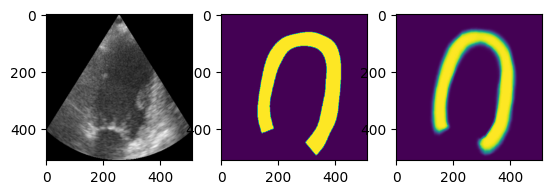

In [10]:
plt.subplot(131)
plt.imshow(imgage)
plt.subplot(132)
plt.imshow(msk)
plt.subplot(133)
plt.imshow(np.transpose(pred.cpu().detach().numpy(), (1, 2, 0)))

(944, 1392, 3)


[mjpeg @ 0x5ff84c4e5240] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5ff84c47a140] unable to decode APP fields: Invalid data found when processing input


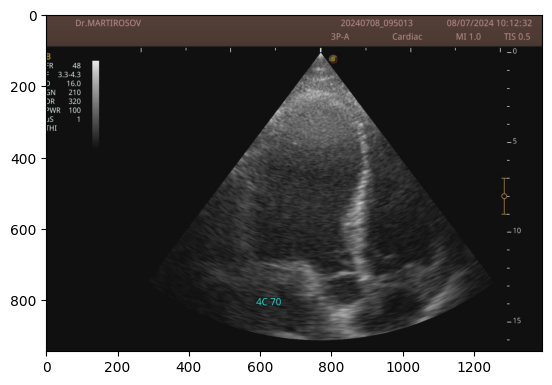

In [11]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame)

In [13]:
new_img = prepare_input(frame)
print(new_img.shape)
pred = model(new_img)[-1]
pred = prepare_output(pred)
pred.shape

torch.Size([1, 3, 512, 512])


(512, 512, 1)

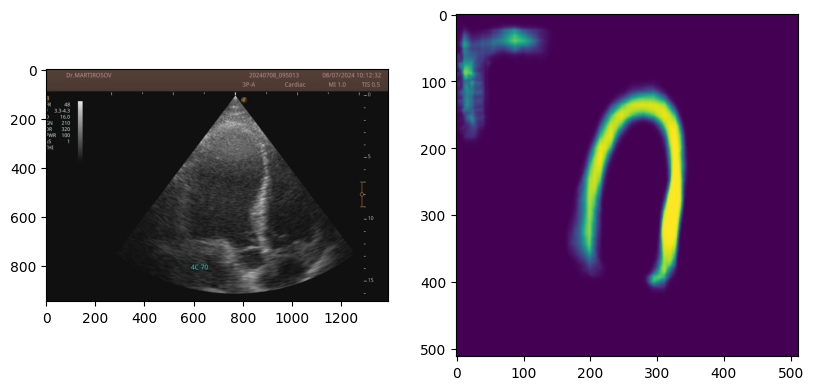

In [14]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(frame)
plt.subplot(132)
plt.imshow(pred)

In [15]:
51+60+43+4000+100

4254

In [ ]:
""" The worst predict """
dices = []

for i in range(len(X_test)):
    pred = model.predict(X_test[i:i + 1], verbose=0)
    # eval = model.evaluate(X_test[i:1 + 1])
    dice = dice_coef(y_test[i:i + 1].astype(np.float32), pred).numpy()
    dices.append([i, dice])

dices = np.array(dices)
sorted_dice = dices[dices[:, 1].argsort()]

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 8), dpi=120)

for j, (i, val) in enumerate(sorted_dice[:5]):
    i = int(i)

    ax[0, j].set_title('Image')
    ax[0, j].set_axis_off()
    ax[0, j].imshow(X_test[i])

    ax[1, j].set_title('Mask')
    ax[1, j].set_axis_off()
    ax[1, j].imshow(y_test[i])

    pred = model.predict(X_test[i:i + 1])
    ax[2, j].set_title(f'Predict: {round(val, 3)}')
    ax[2, j].set_axis_off()
    ax[2, j].imshow(pred[0])

plt.show()